In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
#collect the images and put them in dataframe
with_mask_images = []
without_mask_images = []
i = 0
for file_name in os.listdir("../input/face-mask-dataset/data/with_mask"):
    image =tf.keras.preprocessing.image.load_img(os.path.join("../input/face-mask-dataset/data/with_mask",file_name),target_size=(50,50))
    image = tf.keras.preprocessing.image.img_to_array(image, dtype="float32")
    image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
    with_mask_images.append(image)
    i = i + 1
    if(i > 3500):
        break
j = 0   
for file_name in os.listdir("../input/face-mask-dataset/data/without_mask"):
    image =tf.keras.preprocessing.image.load_img(os.path.join("../input/face-mask-dataset/data/without_mask",file_name),target_size=(50,50))
    image = tf.keras.preprocessing.image.img_to_array(image, dtype="float32")
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    without_mask_images.append(image)
    j = j + 1
    if(j > 3500):
        break
    
df = pd.DataFrame({"images":with_mask_images, "with_mask":[1 for element in with_mask_images]})
without_mask_df = pd.DataFrame({"images":without_mask_images, "with_mask":[0 for element in without_mask_images]})

In [3]:
df = df.append(without_mask_df, ignore_index = True)
df.sample(frac = 1 ,ignore_index = True, random_state = 1)  #shuffle the dataframe


,images,with_mask
0,"[[[-0.90588236, -0.8901961, -0.8980392], [-0.9...",1
1,"[[[0.49803925, 0.4666667, 0.39607847], [0.4980...",0
2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",1
3,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
4,"[[[0.52156866, -0.41176468, -0.47450978], [0.5...",0
...,...,...
6997,"[[[0.8039216, 0.58431375, 0.27058828], [0.8274...",1
6998,"[[[-0.5372549, -0.52156866, -0.6862745], [-0.4...",0
6999,"[[[0.81960785, 0.8039216, 0.8117647], [0.84313...",0
7000,"[[[0.4666667, 0.09019613, -0.5529412], [0.6392...",1


In [4]:
#divide the data to train, cross validation and test sets
x_train, x_test, y_train, y_test  = train_test_split(df["images"],df["with_mask"],test_size=0.4,shuffle = True, random_state=42)
x_cross_validation, x_test, y_cross_validation, y_test  = train_test_split(x_test,y_test,test_size=0.5,shuffle = True, random_state=42)

In [5]:
x_train = np.array([np.array(val) for val in x_train])
x_test = np.array([np.array(val) for val in x_test])
x_cross_validation = np.array([np.array(val) for val in x_cross_validation])

In [6]:
#build the model
model = tf.keras.models.Sequential();
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu',input_shape=(50,50,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten());
model.add(tf.keras.layers.Dense(50, activation= "relu"));
model.add(tf.keras.layers.Dense(50, activation= "relu"));
model.add(tf.keras.layers.Dense(2, activation= "softmax"));
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'])
history = model.fit(x_train, y_train,batch_size=30, epochs = 10, validation_data = (x_cross_validation, y_cross_validation),workers=4)

2022-02-25 12:53:30.067762: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-25 12:53:30.425301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
141/141 [==============================] - 17s 116ms/step - loss: 0.3438 - accuracy: 0.8553 - val_loss: 0.3794 - val_accuracy: 0.8736
Epoch 2/10
141/141 [==============================] - 16s 113ms/step - loss: 0.2325 - accuracy: 0.9103 - val_loss: 0.2064 - val_accuracy: 0.9300
Epoch 3/10
141/141 [==============================] - 16s 114ms/step - loss: 0.1584 - accuracy: 0.9410 - val_loss: 0.1476 - val_accuracy: 0.9500
Epoch 4/10
141/141 [==============================] - 16s 112ms/step - loss: 0.1361 - accuracy: 0.9502 - val_loss: 0.1657 - val_accuracy: 0.9421
Epoch 5/10
141/141 [==============================] - 16s 116ms/step - loss: 0.1283 - accuracy: 0.9538 - val_loss: 0.1602 - val_accuracy: 0.9471
Epoch 6/10
141/141 [==============================] - 16s 113ms/step - loss: 0.0818 - accuracy: 0.9700 - val_loss: 0.2201 - val_accuracy: 0.9293
Epoch 7/10
141/141 [==============================] - 16s 114ms/step - loss: 0.1554 - accuracy: 0.9460 - val_loss: 0.1674 - val_ac

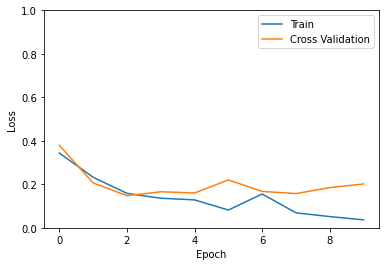

In [7]:
#visualize the loss with the train and crossvalidation
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Cross Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')


In [8]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(val_loss,val_accuracy)

44/44 [==============================] - 1s 32ms/step - loss: 0.2128 - accuracy: 0.9507
0.21282406151294708 0.9507494568824768


In [9]:
#extract the output from the probability distrbution
predictions = np.argmax(model.predict(x_test),axis = 1)
#show the precision, recall and f1_score
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       673
           1       0.96      0.94      0.95       728

    accuracy                           0.95      1401
   macro avg       0.95      0.95      0.95      1401
weighted avg       0.95      0.95      0.95      1401



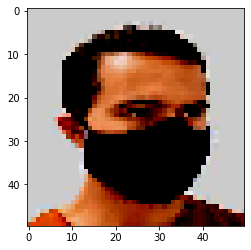

the predicted class is with_mask


In [10]:
predictions_classes = ["without_mask", "with_mask"]
plt.imshow(x_test[0])
plt.show()
print("the predicted class is "+ predictions_classes[predictions[0]])
